# Criando visualização com NDVI e imagem real com o Leaflet

__Autoria:__ Sabrina Paes Leme P. Correa <br>
__Criação:__ 16/07/2024 <br>
__Modificação:__ 16/07/2024

__Dificuldade:__ Fácil <br>
__Descrição:__ Neste tutorial vamos gerar uma imagem NDVI do Sentinel-2/MSI e criar uma visualização do NDVI com a imagem em cor verdadeira
<br>
__Referências:__
* https://leafmap.org/notebooks/49_split_control/
* https://leafmap.org/notebooks/91_raster_viz_gui/#visualizing-local-raster-data
<br>
<br>


__Contato:__ <br>
📧 paeslemesa@gmail.com <br>
🔗 https://www.linkedin.com/in/paeslemesa/?locale=pt_BR <br>
🐱 https://github.com/paeslemesa

## Importando bibliotecas e Determinando nossa entrada de dados

In [1]:
# Descomente a linha abaixo para instalar as bibliotecas necessárias
#!pip install folium rioxarray leafmap locatileserver

In [2]:
from pathlib import Path #biblioteca de manipulação de arquivos

import numpy as np #biblioteca de manipulação de arrays

import matplotlib.pyplot as plt # biblioteca de plotagem de gráficos

import folium
import rioxarray as rxr
import rasterio
import xarray as xr
import leafmap.foliumap as leafmap

import leafmap.colormaps as cm

In [3]:
diretorio = r"./" # diretório onde estão as imagens
camImagem = Path(diretorio, "S2B_MSIL2A_tutorial_epsg4326.tif") # imagem a ser aberta

## 1. Calculando NDVI e salvando imagem

Em primeiro momento, vamos calcular e salvar o NDVI (_Normalized Vegetation Differential Index_) como um raster usando o __Rasterio__.

In [4]:
with rasterio.open(camImagem) as src:
    img = src.read() # Lendo a imagem como NumPy array
    bounds = src.bounds # Obtendo os limites da imagem
    profile = src.profile # Obtendo o perfil da imagem

In [5]:
img = img.astype(np.float32) # Convertendo o array para float32 para evitar problemas de divisão

# Altere aqui para as bandas que você está usando. No meu caso, a banda NIR é a 4 e a Red é a 3
nir = img[3] # Banda NIR
red = img[2] # Banda Red

ndvi = (nir - red) / (nir + red) # Calculando o NDVI

In [6]:
camNDVI = Path(diretorio, f"{camImagem.stem}_ndvi.tif") # Caminho para salvar o NDVI

profile.update(count=1, dtype=rasterio.float32) # Atualizando o perfil da imagem

with rasterio.open(camNDVI, 'w', **profile) as dst:
    dst.write(ndvi, 1) # Salvando o NDVI como um arquivo

## Plotando o mapa com cursos de divisão

In [7]:
# Calculando o centroide da imagem para centralizar noso visualizador
centroidX = (bounds[0] + bounds[2]) / 2
centroidY = (bounds[1] + bounds[3]) / 2
print(f"Centroide da imagem está em: ({np.round(centroidX,3)}, {np.round(centroidY,3)})")

# Calculando valores mínimos e máximos do NDVI para facilitar a visualização
vmin = ndvi.min()
vmax = ndvi.max()

print("Cor mínima:", vmin, "\nCor máxima:", vmax)

Centroide da imagem está em: (-53.904, -4.449)
Cor mínima: -0.13235846 
Cor máxima: 0.645509


Agora vamos criar a parte de plotar realmente o mapa.

Precisamos determinar quem vai ser o mapa da esquerda e quem vai ser o mapa da direita, assim como seus respectivos parâmetros

In [8]:

colors = "viridis" # Para mais opções de mapas de cores, veja: https://matplotlib.org/stable/tutorials/colors/colormaps.html
bandas = [3, 2, 1] # Bandas RGB para visualização

mapa = leafmap.Map(center=[centroidY, centroidX], zoom=20)
mapa.split_map(
    # Parâmetros da imagem da ESQUERDA
    left_layer = str(camImagem), #Caminho da imagem em formato string (texto, str)
    left_args={"layer_name": "Imagem em RGB", # Nome da camada
               "indexes": bandas}, # Bandas que queremos usar
    left_label="Sentinel-2 TCI", left_position="bottomleft", # Posição do rótulo (bottom = baixo, left = esquerda)
    # Parâmetros da imagem da DIREITA
    right_layer = str(camNDVI), # Caminho da imagem em formato string (texto, str)
    right_args={"layer_name": "NDVI", # Nome da camada
                "colormap": colors, # Mapa de cores
                "vmin": vmin, "vmax": vmax}, # Valores mínimo e máximo para facilitar a visualização
    right_label="NDVI", right_position="bottomright" # Posição do rótulo (bottom = baixo, right = direita)
)


mapa # Mostrando o mapa



O resultado deve ser parecido com esse:

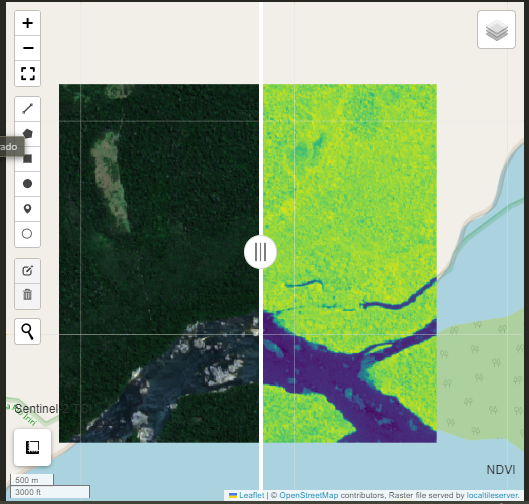

## 3. Salvando o Mapa

Com o mapa em HTM salvo, você pode adicioná-lo a sua página da web

In [9]:
camMapa = Path(diretorio, f"{camImagem.stem}_mapa.html") # nome do arquivo a ser salvo
mapa.save(camMapa) # Salvando o mapa